In [1]:
from fuzzywuzzy import process
import polars as pl
import os
import re
import json

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import pandas as pd
from sklearn.cluster import KMeans
import numpy as np

# Loading stations locations datasets

In [2]:
dir = "./docking_stations_locations"

df_cycle_hire_locations_1 = pl.read_excel(os.path.join(dir,"Cycle_hire_locations.xlsx"))
df_cycle_hire_locations_2 = pl.read_csv(os.path.join(dir,"london-city-bikes-locations.csv"))
df_cycle_hire_locations_3 = pl.read_csv(os.path.join(dir,"cycling-hire-locations-3.csv"))
df_cycle_hire_locations_4 = pl.read_csv(os.path.join(dir,"Copy of FOI 1665 2122.csv"))
df_cycle_hire_locations_5 = pl.read_csv(os.path.join(dir,"FOI 4747 1718.csv"), has_header=True)
df_cycle_hire_locations_6 = pl.read_csv(os.path.join(dir,"Cycle hire docking stations.csv"))
df_cycle_hire_locations_7 = pl.read_csv(os.path.join(dir,"Copy of Foi ref 3468-2223.csv"))



In [4]:
df_cycle_hire_locations_1 = df_cycle_hire_locations_1["name", "latitude", "longitude"]
df_cycle_hire_locations_1 = df_cycle_hire_locations_1.with_columns([
                                                                    pl.col("latitude").cast(pl.Float64),
                                                                    pl.col("longitude").cast(pl.Float64)
                                                                    ])
df_cycle_hire_locations_2 = df_cycle_hire_locations_2["Docking Station", "Latitude", "Longitude"].rename({"Docking Station": "name", "Latitude": "latitude", "Longitude": "longitude"})
df_cycle_hire_locations_3 = df_cycle_hire_locations_3.select([
    pl.col("StationName").alias("name"),  # Rename "StationName" to "name"
    pl.col("latitude"),
    pl.col("longitude")
])

# Strip whitespace and convert "longitude" to Float64
df_cycle_hire_locations_3 = df_cycle_hire_locations_3.with_columns(
    pl.col("longitude").str.replace(" ", "").cast(pl.Float64)
)
df_cycle_hire_locations_4 = df_cycle_hire_locations_4.select([
    pl.col("Docking Station").alias("name"),
    pl.col("Latitude").alias("latitude"),
    pl.col("Longitude").alias("longitude")
])
df_cycle_hire_locations_5 = df_cycle_hire_locations_5.select([
    pl.col("Docking Station Name").alias("name"),
    pl.col("Latitude").alias("latitude"),
    pl.col("Longitude").alias("longitude")
])
df_cycle_hire_locations_6 = df_cycle_hire_locations_6.select([
    pl.col("Docking Station").alias("name"),
    pl.col("Latitude").alias("latitude"),
    pl.col("Longitude").alias("longitude")
])
df_cycle_hire_locations_7 = pl.read_csv(os.path.join(dir,"Copy of Foi ref 3468-2223.csv"))

df_cycle_hire_locations_7 = df_cycle_hire_locations_7.select([
    pl.col("StationName").alias("name"),
    pl.col("latitude").alias("latitude"),
    pl.col("longitude").alias("longitude")
])

df_cycle_hire_locations_7 = df_cycle_hire_locations_7.with_columns(
    pl.col("longitude").str.replace(" ", "").cast(pl.Float64)
)

In [5]:
all_stations_locations = pl.concat([df_cycle_hire_locations_1, 
                                    df_cycle_hire_locations_2,
                                    df_cycle_hire_locations_3,
                                    df_cycle_hire_locations_5,
                                    ])
all_stations_locations = all_stations_locations.with_columns(pl.col(pl.Float64).round(4))
all_stations_locations = all_stations_locations.unique().sort(by='name')
all_stations_locations

name,latitude,longitude
str,f64,f64
"""Abbey Orchard Street, Westmins…",51.4981,-0.1321
"""Abbotsbury Road, Holland Park""",51.5014,-0.206
"""Aberdeen Place, St John's Wood""",51.5248,-0.1763
"""Aberdeen Place, St. John's Woo…",51.5248,-0.1763
"""Aberfeldy Street, Poplar""",51.5135,-0.0057
…,…,…
"""Wright's Lane, Kensington""",51.5004,-0.1931
"""Wynne Road, Stockwell""",51.4692,-0.1127
"""York Hall, Bethnal Green""",51.5289,-0.0559


# Handling duplicates in locations dataframe and data cleaning

In [7]:
duplicate_locations_rows = all_stations_locations.filter(
    all_stations_locations.select(['longitude', 'latitude']).is_duplicated()
)
duplicate_locations_rows

name,latitude,longitude
str,f64,f64
"""Aberdeen Place, St John's Wood""",51.5248,-0.1763
"""Aberdeen Place, St. John's Woo…",51.5248,-0.1763
"""Abingdon Green, Great College …",51.4976,-0.126
"""Abingdon Green, Westminster""",51.4976,-0.126
"""Albany Street, Regent's Park""",51.5283,-0.1445
…,…,…
"""Whiteley's, Bayswater""",51.5103,-0.1874
"""Winsland Street, Paddington""",51.5183,-0.1711
"""Worship Street, Shoreditch""",51.5217,-0.0811


In [10]:
def change_station_location(df, name, latitude, longitude): 
    df = df.with_columns(
        pl.when(pl.col("name") == name)
        .then(latitude)
        .otherwise(pl.col("latitude"))
        .alias("latitude"),

        pl.when(pl.col("name") == name)
        .then(longitude)
        .otherwise(pl.col("longitude"))
        .alias("longitude")
    )
    return df

In [12]:
all_stations_locations.filter(
    pl.col(['name']) == "Birkenhead Street, King's Cross"
)

name,latitude,longitude
str,f64,f64
"""Birkenhead Street, King's Cros…",51.5302,-0.1223


In [11]:
all_stations_locations = change_station_location(all_stations_locations, "South Quay West, Canary Wharf", 51.5026, -0.0227)
all_stations_locations = change_station_location(all_stations_locations, "Lansdowne Way Bus Garage, Stockwell", 51.4746, -0.1246)
all_stations_locations = change_station_location(all_stations_locations, "Milford Lane, Temple", 51.5121, -0.1129)
all_stations_locations = change_station_location(all_stations_locations, "Arundel Street, Temple", 51.5117, -0.1139)
all_stations_locations = change_station_location(all_stations_locations, "Thessaly Road North, Nine Elms", 51.4766, -0.1379)
all_stations_locations = change_station_location(all_stations_locations, "Walworth Road, Elephant & Castle", 51.4934, -0.0997)
all_stations_locations = change_station_location(all_stations_locations, "One Tower Bridge, Bermondsey", 51.5031, -0.0787)
all_stations_locations = change_station_location(all_stations_locations, "Import Dock, Canary Wharf", 51.5058, -0.0165)
all_stations_locations = change_station_location(all_stations_locations, "Bourne Street, Belgravia", 51.491, -0.1532)
all_stations_locations = change_station_location(all_stations_locations, "Dock Street, Wapping"	, 51.5084, -0.0672)
all_stations_locations = change_station_location(all_stations_locations, "Whiteley's, Bayswater", 51.5148, -0.1881)
all_stations_locations = change_station_location(all_stations_locations, "Grant Road West, Clapham Junction", 51.4644, -0.1746)
all_stations_locations = change_station_location(all_stations_locations, "Winsland Street, Paddington", 51.5168, -0.1755)
all_stations_locations = change_station_location(all_stations_locations, "Worship Street, Shoreditch", 51.5217, -0.0811)
all_stations_locations = change_station_location(all_stations_locations, "The Green Bridge, Mile End", 51.5247, -0.0356)
all_stations_locations = change_station_location(all_stations_locations, "Merchant Street, Bow", 51.5261, -0.0274)
all_stations_locations = change_station_location(all_stations_locations, "Euston Square Gardens, Euston", 51.5271, -0.1319)
all_stations_locations = change_station_location(all_stations_locations, "Lodge Road, St. John's Wood", 51.5283, -0.1701)
all_stations_locations = change_station_location(all_stations_locations, "Westfield Wood Lane, White City (REMOVED)", 51.5078, -0.2187)
all_stations_locations = change_station_location(all_stations_locations, "Gauden Road, Clapham", 51.465, -0.1309)
all_stations_locations = change_station_location(all_stations_locations, "Bonner Gate, Victoria Park", 51.5334, -0.0496)
all_stations_locations = change_station_location(all_stations_locations, "Birkenhead Street, King's Cross", 51.5302, -0.1223)

all_stations_locations = all_stations_locations.unique().sort(by='name')

In [13]:
print(all_stations_locations.columns)
all_stations_locations.shape

['name', 'latitude', 'longitude']


(1030, 3)

In [14]:
# Group by latitude and longitude and create a canonical name (first name in the group)
unique_stations_locations = (
    all_stations_locations
    .group_by(["latitude", "longitude"])
    .agg(pl.col("name").first().alias("canonical_name"))
)
print(unique_stations_locations.columns)
unique_stations_locations.shape
unique_stations_locations

['latitude', 'longitude', 'canonical_name']


latitude,longitude,canonical_name
f64,f64,str
51.4959,-0.1919,"""Lexham Gardens, Kensington"""
51.5314,-0.1171,"""Calshot Street , King's Cross"""
51.4961,-0.2082,"""Olympia Way, Olympia"""
51.5264,-0.1093,"""Tysoe Street, Clerkenwell"""
51.5284,-0.1047,"""St. John Street, Finsbury"""
…,…,…
51.5007,-0.1297,"""Storey's Gate, Westminster"""
51.5149,-0.0661,"""LMU Commercial Road, Whitechap…"
51.4881,-0.1209,"""Vauxhall Walk, Vauxhall"""


Join with the original dataframe to map all names to their canonical name


In [45]:
coordinate_based_mapping = (
    all_stations_locations
    .join(unique_stations_locations, on=["latitude", "longitude"], how="left")
    .select(["name", "canonical_name"])
    .unique()
)
coordinate_based_mapping #duplicates in "name" column - need to remove them and leave first value in canonical_name 
                         #(higher priority when name == canonical_name)

name,canonical_name
str,str
"""Pall Mall East, West End""","""Pall Mall East, West End"""
"""Queen Victoria Street, St. Pau…","""Queen Victoria Street, St. Pau…"
"""Coborn Street, Mile End""","""Coborn Street, Bow"""
"""Fulham Broadway, Walham Green""","""Fulham Broadway, Walham Green"""
"""Gas Holders, Battersea Park""","""Gas Holders, Battersea Park"""
…,…
"""Tavistock Place, Bloomsbury""","""Tavistock Place, Bloomsbury"""
"""Westferry Circus, Canary Wharf""","""Westferry Circus, Canary Wharf"""
"""Waterloo Station 1, Waterloo""","""Waterloo Station 1, Waterloo"""


Ensure that names are unique across the entire dataset. 

If a name appears with multiple coordinates, it should not be mapped to a single canonical name.

We'll do this by checking if a name appears more than once in the canonical_names mapping

In [46]:
name_counts = (
    coordinate_based_mapping
    .group_by("name")
    .agg(pl.count().alias("count"))
)
duplicate_name_counts = name_counts.filter(pl.col("count") > 1)
duplicate_name_counts

C:\Users\huber\AppData\Local\Temp\ipykernel_22904\596949442.py:4: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias("count"))


name,count
str,u32
"""Belvedere Road 2, South Bank""",2
"""Concert Hall Approach 2, South…",2
"""St. John's Wood Church, The Re…",2
"""Here East South, Queen Elizabe…",2
"""Central House, Aldgate""",2
"""Waterloo Station 2, Waterloo""",2
"""Exhibition Road, Knightsbridge""",2
"""Royal Avenue 2, Chelsea""",2
"""Waterloo Station 3, Waterloo""",2


In [47]:
def change_station_canonical_name(df, name, canonical_name):
    df = df.with_columns(
        pl.when(pl.col("name") == name)
        .then(pl.lit(canonical_name))
        .otherwise(pl.col("canonical_name"))
        .alias("canonical_name")
    )
    return df

In [48]:
filterd = coordinate_based_mapping.filter(pl.col("name") == "Belvedere Road 2, South Bank")
filterd

name,canonical_name
str,str
"""Belvedere Road 2, South Bank""","""Belvedere Road 2, South Bank"""
"""Belvedere Road 2, South Bank""","""Belvedere Road 1, South Bank"""


For all duplicates I change canonical name to one option.

In [49]:
coordinate_based_mapping = change_station_canonical_name(coordinate_based_mapping, "Waterloo Station 2, Waterloo", "Waterloo Station 1, Waterloo")
coordinate_based_mapping = change_station_canonical_name(coordinate_based_mapping, "Waterloo Station 3, Waterloo", "Waterloo Station 1, Waterloo")
coordinate_based_mapping = change_station_canonical_name(coordinate_based_mapping, "Central House, Aldgate", "Central House, Aldgate")
coordinate_based_mapping = change_station_canonical_name(coordinate_based_mapping, "Exhibition Road, Knightsbridge"	, "Exhibition Road, Knightsbridge")
coordinate_based_mapping = change_station_canonical_name(coordinate_based_mapping, "Here East South, Queen Elizabeth Olympic Park", "Here East South, Queen Elizabeth Olympic Park")
coordinate_based_mapping = change_station_canonical_name(coordinate_based_mapping, "St. John's Wood Church, The Regent's Park", "St. John's Wood Church, The Regent's Park")
coordinate_based_mapping = change_station_canonical_name(coordinate_based_mapping, "Royal Avenue 2, Chelsea", "Royal Avenue 2, Chelsea")
coordinate_based_mapping = change_station_canonical_name(coordinate_based_mapping, "Southwark Station 2, Southwark", "Southwark Station 2, Southwark")
coordinate_based_mapping = change_station_canonical_name(coordinate_based_mapping, "Concert Hall Approach 2, South Bank", "Concert Hall Approach 2, South Bank")
coordinate_based_mapping = change_station_canonical_name(coordinate_based_mapping, "Belvedere Road 2, South Bank", "Belvedere Road 2, South Bank")


In [50]:
coordinate_based_mapping = coordinate_based_mapping.unique()

In [51]:
# Filter out names that appear more than once (i.e., they have multiple coordinates)
name_counts = (
    coordinate_based_mapping
    .group_by("name")
    .agg(pl.count().alias("count"))
)

unique_names = name_counts.filter(pl.col("count") == 1)["name"]
unique_names

C:\Users\huber\AppData\Local\Temp\ipykernel_22904\1941678559.py:5: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias("count"))


name
str
"""Melton Street, Euston"""
"""Baylis Road, Waterloo"""
"""Eversholt Street , Camden Town"""
"""Eagle Wharf Road, Hoxton"""
"""Woodstock Grove, Shepherd's Bu…"
…
"""Wansey Street, Walworth"""
"""Albert Square, Stockwell"""
"""Dickens Square, The Borough"""


In [52]:
"Waterloo Station 2, Waterloo" in set(unique_names)

True

In [53]:
# Update coordinate_based_mapping to only include names that are unique
coordinate_based_mapping = (
    coordinate_based_mapping
    .filter(pl.col("name").is_in(unique_names))                             
    .to_pandas()  # Convert to Pandas for easier dictionary creation
    .set_index("name")["canonical_name"]
    .to_dict()
)

In [54]:
print(len(coordinate_based_mapping))
coordinate_based_mapping

1000


{'Ebury Bridge, Pimlico': 'Ebury Bridge, Pimlico',
 'Broadwick Street, Soho': 'Broadwick Street, Soho',
 'Broomhouse Lane, Parsons Green': 'Broomhouse Lane, Parsons Green',
 'Bevington Road, North Kensington': 'Bevington Road, North Kensington',
 'Vauxhall Bridge, Pimlico': 'Vauxhall Bridge , Pimlico',
 'Pitfield Street Central, Hoxton': 'Pitfield Street (North), Hoxton',
 'Finsbury Circus, Liverpool Street': 'Finsbury Circus, Liverpool Street',
 'Bermondsey Street, Bermondsey': 'Bermondsey Station, Bermondsey',
 'Hop Exchange, The Borough': 'Hop Exchange, The Borough',
 'Marloes Road, Kensington': 'Marloes Road, Kensington',
 'Wapping Lane, Wapping': 'Wapping Lane, Wapping',
 'Lexham Gardens, Kensington': 'Lexham Gardens, Kensington',
 'Russell Gardens, Holland Park': 'Russell Gardens, Holland Park',
 'Ford Road, Old Ford': 'Ford Road, Old Ford',
 'Waterloo Station 3, Waterloo': 'Waterloo Station 1, Waterloo',
 'Everington Street, Fulham': 'Everington Street, Fulham',
 'Hewison Street

# Loading all unique names from whole dataset

In [55]:
# Define paths and configurations
dir = "./tfl_cycling_data"
csv_files = [os.path.join(dir, f) for f in os.listdir(dir) if f.endswith(".csv")]

# Column mapping and columns to drop
column_mapping = {
    'Duration': 'Duration_Seconds',
    'End date': 'End Date',
    'EndStation Name': 'End station',
    'End Station Name': 'End station',
    'Start date': 'Start Date',
    'StartStation Name': 'Start station',
    'Start Station Name': 'Start station',
    'EndStation Id': 'End Station Id',
    'StartStation Id': 'Start Station Id',
    }

columns_to_drop = ['Bike Id', 'Bike model', 'Bike number','Rental Id', 
                   'Number', 'Total duration', 'Total duration (ms)', 
                   'Start station number', 'End station number', ]

In [56]:
def get_unique_stations_names(csv_files):
    station_set = set()

    # Process each file to collect unique stations and determine date range
    # Read CSV into Polars DataFrame, ignoring schema errors
    for file_path in csv_files:
        df = pl.read_csv(file_path, ignore_errors=True)

        # Rename columns
        for old_name, new_name in column_mapping.items():
            if old_name in df.columns:
                df = df.rename({old_name: new_name})
       
        start_stations = df["Start station"].unique().to_list()
        end_stations = df["End station"].unique().to_list()
        station_set.update(start_stations)
        station_set.update(end_stations)
        station_set.discard(None)
    return station_set

In [57]:
unique_station_names = get_unique_stations_names(csv_files)
print(len(unique_station_names))
print(unique_station_names)

880
{'Bedford Way, Bloomsbury', 'Westbourne Grove, Bayswater', 'The Metropolitan, Portobello', 'City Road, Angel', "St. James's Square, St. James's", 'Norton Folgate, Liverpool Street', 'Mechanical Workshop Clapham', 'Grenfell Road, Avondale', "Queen Mary's, Mile End", 'Pindar Street, Liverpool Street', 'Albert Gate, Hyde Park', 'Vincent Street, Pimlico', 'Normand Park, West Kensington', 'Palace Gate, Kensington Gardens', 'Northington Street , Holborn', 'Doric Way , Somers Town', "Whiteley's, Bayswater", 'George Row, Bermondsey', 'Page Street, Westminster', 'Bruton Street, Mayfair', 'Globe Town Market, Bethnal Green', 'Great Russell Street, Bloomsbury', 'Park Lane, Mayfair', 'Bayswater Road, Hyde Park', 'Ravenscourt Park Station, Hammersmith', 'Sidney Road, Stockwell', 'Saltoun Road, Brixton', 'Clifton Road, Maida Vale', 'Napier Avenue, Millwall', 'Kensington Town Hall, Kensington', 'Kennington Lane Tesco, Vauxhall', 'LSBU (Borough Road), Elephant & Castle', 'Normandy Road, Stockwell',

Create name mapping for unique stations names

In [71]:
def extend_name_mapping(unique_station_names, mapping, threshold=90):
    # Convert unique_station_names to a list (if it's a Polars Series)
    unique_station_names = list(unique_station_names)

    # Create a set to track names that have already been mapped
    processed_names = set(mapping.keys())

    # Iterate through each new name
    for name in unique_station_names:
        if name not in processed_names:
            # Use fuzzy matching to find similar names in mapping
            matches = process.extract(name, mapping.values(), limit=None)
            best_match = None
            for match, score in matches:
                if score >= threshold:
                    best_match = match
                    break
                
            print(f"{name}: {best_match}")
            # If a similar name is found, map the new name to its canonical name
            if best_match:
                #canonical_name = mapping[best_match]
                mapping[name] = best_match
                processed_names.add(name)
            else:
                # If no similar name is found, add the new name as its own canonical name
                mapping[name] = name
                processed_names.add(name)

    return mapping

In [72]:
name_mapping = extend_name_mapping(unique_station_names, coordinate_based_mapping.copy())

Mechanical Workshop Clapham: None
Disraeli Road, Putney2: Disraeli Road, Putney
Canada Water Station: Canada Water Station, Rotherhithe
Strand, Strand_OLD: Strand, Strand
One London: None
Pop Up Dock 2: None
Worship Street, Hackney: None
Allington street, Off Victoria Street, Westminster: None
Mechanical Workshop Penton: None
Argyle Street, Kings Cross: None
York Way, Camden: None
Cartier Circle, Canary Wharf: None
Pop Up Dock 1: Pop Up Dock 2
Hardwick Street, Clerkenwell_old2: Hardwick Street, Clerkenwell
Queensway, Westminster: None
Exhibition Road, South Kensington: Exhibition Road Museums 1, South Kensington
Import Dock: Import Dock, Canary Wharf
Elgin Avenue, Maida Hill: None
LSP2: None
Exhibition Road Museums, Knightsbridge: Exhibition Road, Knightsbridge
Coomer Place, West Kensington_OLD: Coomer Place, West Kensington
Allington street, Westminster, SW1E 5EB: None
Lansdown Drive, Hackney Central: Lansdowne Drive, Hackney Central
LSP1: None
Queensway, Paddington: None
Clapham Sout

In [73]:
name_set_after_mapping = set()

for name in unique_station_names:
    # Get the replacement, or keep the original if not in mapping
    replacement = name_mapping.get(name, name)
    
    if isinstance(replacement, list):
        replacement = replacement[0]
    
    name_set_after_mapping.add(replacement)

# If you want to replace the original set
print(len(name_set_after_mapping))
name_set_after_mapping

851


{'Abbey Orchard Street, Westminster',
 'Abbotsbury Road, Holland Park',
 "Aberdeen Place, St John's Wood",
 'Aberfeldy Street, Poplar',
 'Abingdon Green, Great College Street',
 'Abingdon Villas, Kensington',
 'Abyssinia Close, Clapham Junction',
 'Ackroyd Drive, Bow',
 'Ada Street, Hackney Central',
 'Addison Road, Holland Park',
 'Aintree Street, Fulham',
 "Albany Street, Regent's Park",
 'Albert Bridge Road, Battersea Park',
 'Albert Embankment, Vauxhall',
 'Albert Gardens, Stepney',
 'Albert Gate, Hyde Park',
 'Albert Square, Stockwell',
 'Alderney Street, Pimlico',
 'Aldersgate Street, Barbican',
 'Alfred Place, Bloomsbury',
 'Alfreda Street, Battersea Park',
 'All Saints Church, Portobello',
 "All Saints' Road, Portobello",
 'Allington Street, Victoria',
 'Allington street, Off Victoria Street, Westminster',
 'Allington street, Westminster, SW1E 5EB',
 'Alma Road, Wandsworth',
 'Alpha Grove, Millwall',
 'Ampton Street , Clerkenwell',
 'Ansell House, Stepney',
 'Antill Road, Mile 

In [74]:
unique_stations_locations

latitude,longitude,canonical_name
f64,f64,str
51.4959,-0.1919,"""Lexham Gardens, Kensington"""
51.5314,-0.1171,"""Calshot Street , King's Cross"""
51.4961,-0.2082,"""Olympia Way, Olympia"""
51.5264,-0.1093,"""Tysoe Street, Clerkenwell"""
51.5284,-0.1047,"""St. John Street, Finsbury"""
…,…,…
51.5007,-0.1297,"""Storey's Gate, Westminster"""
51.5149,-0.0661,"""LMU Commercial Road, Whitechap…"
51.4881,-0.1209,"""Vauxhall Walk, Vauxhall"""


In [75]:
name_mapping['Contact Centre, Southbury House']

'Contact Centre, Southbury House'

In [76]:
joined_all_stations_set = unique_station_names.union(set(coordinate_based_mapping.keys()))
joined_all_stations_set.discard(None)
len(joined_all_stations_set)

1026

In [77]:
differenece_set = name_set_after_mapping.difference(set(unique_stations_locations["canonical_name"]))
print(len(differenece_set))
differenece_set

17


{'Allington street, Off Victoria Street, Westminster',
 'Allington street, Westminster, SW1E 5EB',
 'Argyle Street, Kings Cross',
 'Cartier Circle, Canary Wharf',
 'Clapham South, Clapham South',
 'Elgin Avenue, Maida Hill',
 'Here East South, Queen Elizabeth Olympic Park',
 'LSP1',
 'LSP2',
 'Mechanical Workshop Clapham',
 'Mechanical Workshop Penton',
 'One London',
 'Pop Up Dock 2',
 'Queensway, Paddington',
 'Queensway, Westminster',
 'Worship Street, Hackney',
 'York Way, Camden'}

In [78]:
name_mapping["Allington street, Off Victoria Street, Westminster"] = "Allington Street, Victoria"
name_mapping["Allington street, Westminster, SW1E 5EB"] = "Allington Street, Victoria"
name_mapping["Worship Street, Hackney"] = "Worship Street, Shoreditch"
name_mapping["York Way, Camden"] = "York Way, King's Cross"

In [79]:
name_set_after_mapping = set()

for name in unique_station_names:
    # Get the replacement, or keep the original if not in mapping
    replacement = name_mapping.get(name, name)
    
    if isinstance(replacement, list):
        replacement = replacement[0]
    
    name_set_after_mapping.add(replacement)

differenece_set = name_set_after_mapping.difference(set(unique_stations_locations["canonical_name"]))
print(len(differenece_set))
differenece_set

14


{'Argyle Street, Kings Cross',
 'Cartier Circle, Canary Wharf',
 'Clapham South, Clapham South',
 'Elgin Avenue, Maida Hill',
 'Here East South, Queen Elizabeth Olympic Park',
 'LSP1',
 'LSP2',
 'Mechanical Workshop Clapham',
 'Mechanical Workshop Penton',
 'One London',
 'Pop Up Dock 2',
 'Queensway, Paddington',
 'Queensway, Westminster',
 'Worship Street, Shoreditch'}

# Clustering

In [81]:
unique_stations_locations

latitude,longitude,canonical_name
f64,f64,str
51.4959,-0.1919,"""Lexham Gardens, Kensington"""
51.5314,-0.1171,"""Calshot Street , King's Cross"""
51.4961,-0.2082,"""Olympia Way, Olympia"""
51.5264,-0.1093,"""Tysoe Street, Clerkenwell"""
51.5284,-0.1047,"""St. John Street, Finsbury"""
…,…,…
51.5007,-0.1297,"""Storey's Gate, Westminster"""
51.5149,-0.0661,"""LMU Commercial Road, Whitechap…"
51.4881,-0.1209,"""Vauxhall Walk, Vauxhall"""


In [82]:
unique_stations_locations.filter(pl.col("latitude") > 51.6)

latitude,longitude,canonical_name
f64,f64,str
51.6495,-0.0577,"""Contact Centre, Southbury Hous…"


In [84]:
unique_stations_locations = unique_stations_locations.filter(pl.col("latitude") <= 51.6)
unique_stations_locations

latitude,longitude,canonical_name
f64,f64,str
51.4959,-0.1919,"""Lexham Gardens, Kensington"""
51.5314,-0.1171,"""Calshot Street , King's Cross"""
51.4961,-0.2082,"""Olympia Way, Olympia"""
51.5264,-0.1093,"""Tysoe Street, Clerkenwell"""
51.5284,-0.1047,"""St. John Street, Finsbury"""
…,…,…
51.5007,-0.1297,"""Storey's Gate, Westminster"""
51.5149,-0.0661,"""LMU Commercial Road, Whitechap…"
51.4881,-0.1209,"""Vauxhall Walk, Vauxhall"""


In [90]:
pandas_unique_stations_locations = pd.DataFrame(unique_stations_locations, columns=["latitude", "longitude", "canonical_name"])
pandas_unique_stations_locations = pandas_unique_stations_locations.sort_values(by=["longitude"])
X = pandas_unique_stations_locations[["latitude", "longitude"]].to_numpy()

In [91]:
kmeans = KMeans(n_clusters=30, random_state=0, n_init="auto").fit(X)

c:\Users\huber\anaconda3\envs\torch-cuda\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [92]:
pandas_unique_stations_locations

,latitude,longitude,canonical_name
179,51.4942,-0.2368,"Ravenscourt Park Station, Hammersmith"
173,51.4926,-0.2341,"Hammersmith Town Hall, Hammersmith"
149,51.4921,-0.2291,"Bridge Avenue, Hammersmith"
772,51.4945,-0.2282,"Southerton Road, Hammersmith"
171,51.4881,-0.2266,"Crisp Road, Hammersmith"
...,...,...,...
579,51.4934,-0.0075,"Jubilee Crescent, Cubitt Town"
18,51.509,-0.007,"Naval Row, Blackwall"
505,51.5135,-0.0057,"Aberfeldy Street, Poplar"
195,51.5418,-0.0048,"Stratford Station, Queen Elizabeth Olympic Park"


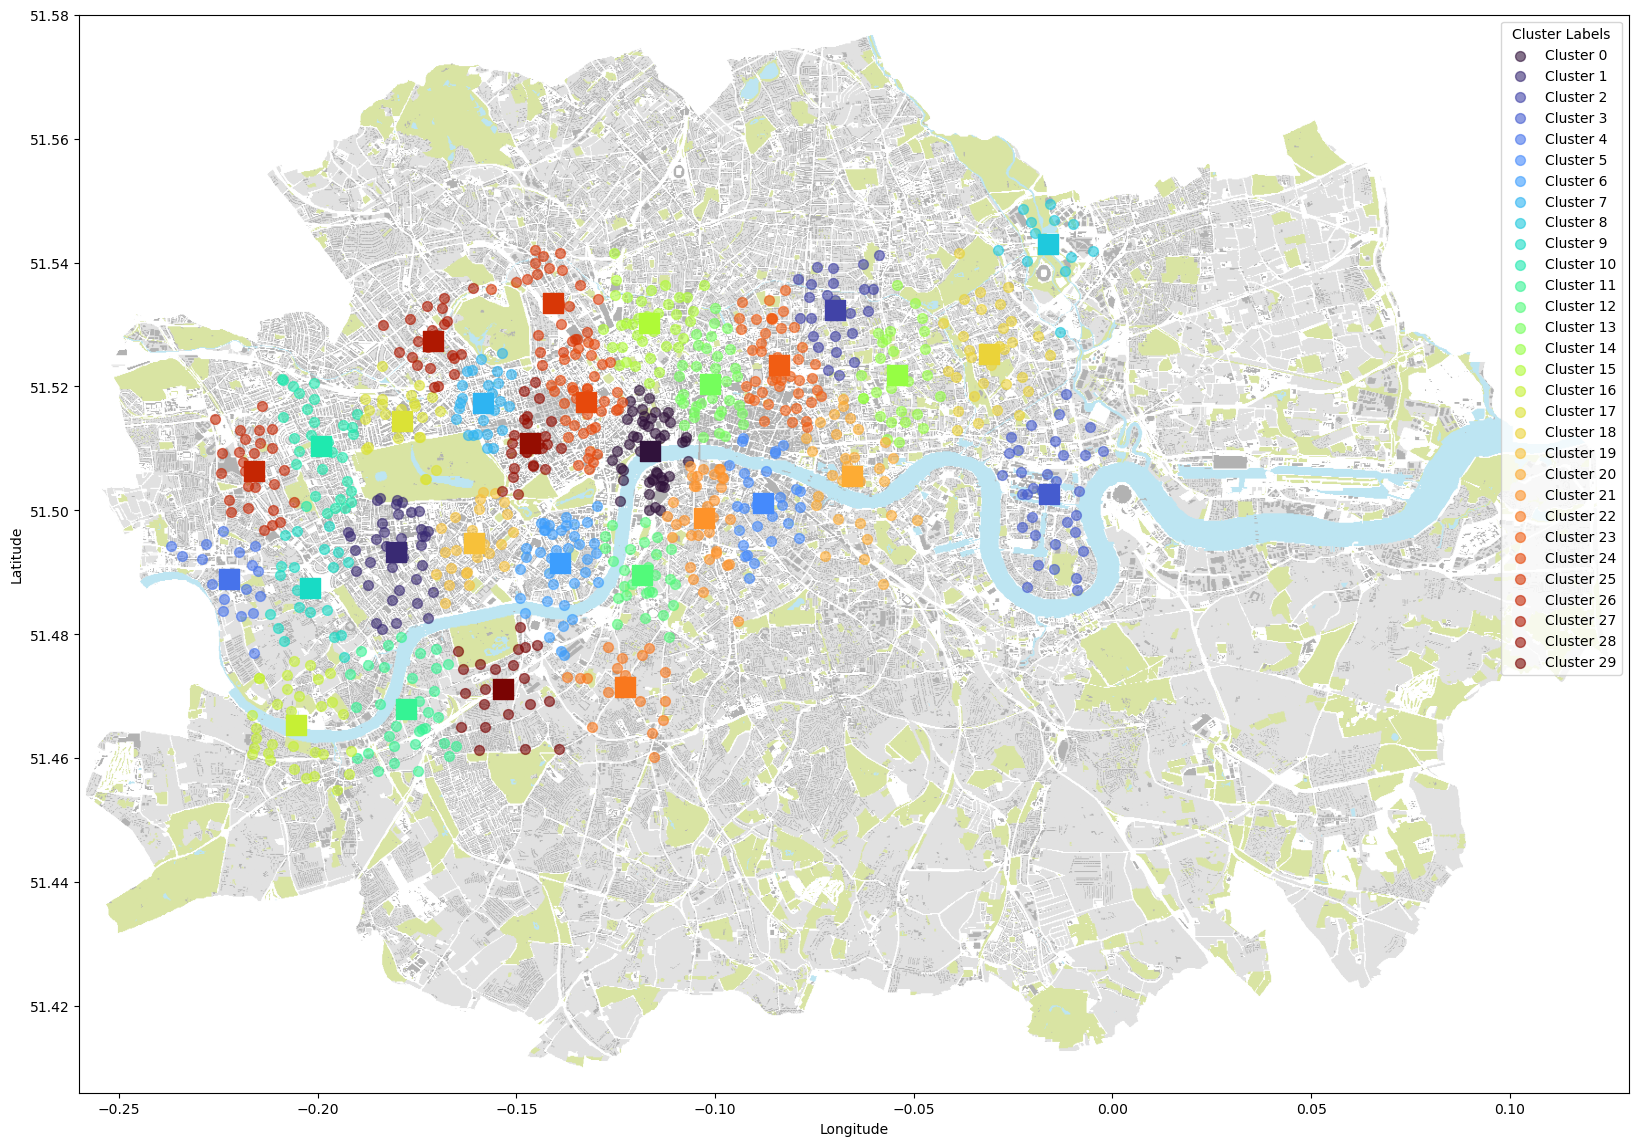

In [93]:
# Load the image
img = mpimg.imread('./images/13.png')

# Define the extent of the image (xmin, xmax, ymin, ymax)
img_extent = [-0.26, 0.13, 51.406, 51.58]

# Create a figure with a larger size
plt.figure(figsize=(20, 14))

# Display the image
plt.imshow(img, extent=img_extent, alpha=1)  # Adjust alpha for transparency

# Overlay the scatter plot with colors based on kmeans.labels_
unique_labels = np.unique(kmeans.labels_)
colors = plt.cm.turbo(np.linspace(0, 1, len(unique_labels)))  # Use a colormap

for label, color in zip(unique_labels, colors):
    # Filter data points for the current label
    mask = kmeans.labels_ == label
    plt.scatter(pandas_unique_stations_locations['longitude'][mask],
                pandas_unique_stations_locations['latitude'][mask],
                color=color, label=f'Cluster {label}', alpha=0.6, s=50)

for cluster_center, color in zip(kmeans.cluster_centers_, colors):
    plt.scatter(cluster_center[1], cluster_center[0],
                color=color, alpha=1, s=200, marker="s")

# Add labels and legend
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Cluster Labels')

# Set the aspect ratio to match the image
plt.gca().set_aspect('auto')  # Use 'auto' or 'equal' depending on your data

# Show the plot
plt.show()

# Saving files

In [94]:
pandas_unique_stations_locations["cluster_label"] = kmeans.labels_

In [96]:
stations_clusters = pd.DataFrame({"cluster_label": np.linspace(0,len(kmeans.cluster_centers_)-1, 30, dtype=np.int32),
                                  "cluster_center_latitude": kmeans.cluster_centers_[:,0],
                                  "cluster_center_longitude: ": kmeans.cluster_centers_[:,1]})
stations_clusters

,cluster_label,cluster_center_latitude,cluster_center_longitude:
0,0,51.509644,-0.116452
1,1,51.493289,-0.180395
2,2,51.532333,-0.069754
3,3,51.502680,-0.015860
4,4,51.488956,-0.222217
5,5,51.501107,-0.087939
6,6,51.491460,-0.139085
7,7,51.517307,-0.158322
8,8,51.542925,-0.016167
9,9,51.487455,-0.202010


In [97]:
pandas_unique_stations_locations

,latitude,longitude,canonical_name,cluster_label
179,51.4942,-0.2368,"Ravenscourt Park Station, Hammersmith",4
173,51.4926,-0.2341,"Hammersmith Town Hall, Hammersmith",4
149,51.4921,-0.2291,"Bridge Avenue, Hammersmith",4
772,51.4945,-0.2282,"Southerton Road, Hammersmith",4
171,51.4881,-0.2266,"Crisp Road, Hammersmith",4
...,...,...,...,...
579,51.4934,-0.0075,"Jubilee Crescent, Cubitt Town",3
18,51.509,-0.007,"Naval Row, Blackwall",3
505,51.5135,-0.0057,"Aberfeldy Street, Poplar",3
195,51.5418,-0.0048,"Stratford Station, Queen Elizabeth Olympic Park",8


In [98]:
unique_stations_locations = unique_stations_locations[["canonical_name", "latitude", "longitude"]]
unique_stations_locations

canonical_name,latitude,longitude
str,f64,f64
"""Lexham Gardens, Kensington""",51.4959,-0.1919
"""Calshot Street , King's Cross""",51.5314,-0.1171
"""Olympia Way, Olympia""",51.4961,-0.2082
"""Tysoe Street, Clerkenwell""",51.5264,-0.1093
"""St. John Street, Finsbury""",51.5284,-0.1047
…,…,…
"""Storey's Gate, Westminster""",51.5007,-0.1297
"""LMU Commercial Road, Whitechap…",51.5149,-0.0661
"""Vauxhall Walk, Vauxhall""",51.4881,-0.1209


In [102]:
pandas_unique_stations_locations.to_csv("./data/stations_locations.csv")

In [104]:
with open("./data/name_mapping.json", "w") as json_file:
    json.dump(name_mapping, json_file, indent=4)

In [ ]:
# There is should add mapping from unique_names to cluster. Stations without a cluster should be assigned to '30' cluster